# Customer Lifetime Value (CLV) Analysis

In this case study, we are going to work with the online-retail dataset from [Kaggle]('https://www.kaggle.com/vijayuv/onlineretail').

This is a transnational data containing all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based. Attribute Information
* *InvoiceNo*: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

* *StockCode*: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

* *Description*: Product (item) name. Nominal.

* *Quantity*: The quantities of each product (item) per transaction. Numeric.

* *InvoiceDate*: Invoice Date and time. Numeric, the day and time when each transaction was generated.

* *UnitPrice*: Unit price. Numeric, Product price per unit in sterling.

* *CustomerID*: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

* *Country*: Country name. Nominal, the name of the country where each customer resides.

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the df
df = pd.read_csv("OnlineRetail.csv", encoding = "unicode_escape", parse_dates = ['InvoiceDate'])
print("Data total records: "+ str(df.shape[0]))

df['Revenue'] = df['Quantity'].multiply(df['UnitPrice'])
df_clv = df[['CustomerID', 'InvoiceNo', 'InvoiceDate', 'Quantity', 'UnitPrice', 'Revenue']]
df_clv = df_clv[df_clv['Revenue'] > 0]
df_clv = df_clv[df_clv['CustomerID'].notnull()]

dfset total records: 541909


In [3]:
df_clv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   CustomerID   397884 non-null  float64       
 1   InvoiceNo    397884 non-null  object        
 2   InvoiceDate  397884 non-null  datetime64[ns]
 3   Quantity     397884 non-null  int64         
 4   UnitPrice    397884 non-null  float64       
 5   Revenue      397884 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 21.2+ MB


In [4]:
df_clv.head()

,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,Revenue
0,17850.0,536365,2010-12-01 08:26:00,6,2.55,15.30
1,17850.0,536365,2010-12-01 08:26:00,6,3.39,20.34
2,17850.0,536365,2010-12-01 08:26:00,8,2.75,22.00
3,17850.0,536365,2010-12-01 08:26:00,6,3.39,20.34
4,17850.0,536365,2010-12-01 08:26:00,6,3.39,20.34


In [5]:
df_clv.describe()

,CustomerID,Quantity,UnitPrice,Revenue
count,397884.000000,397884.000000,397884.000000,397884.000000
mean,15294.423453,12.988238,3.116488,22.397000
std,1713.141560,179.331775,22.097877,309.071041
min,12346.000000,1.000000,0.001000,0.001000
25%,13969.000000,2.000000,1.250000,4.680000
50%,15159.000000,6.000000,1.950000,11.800000
75%,16795.000000,12.000000,3.750000,19.800000
max,18287.000000,80995.000000,8142.750000,168469.600000


In [6]:
df_clv.nunique()

CustomerID      4338
InvoiceNo      18532
InvoiceDate    17282
Quantity         301
UnitPrice        440
Revenue         2939
dtype: int64

Finally, all the required cleaning of the df is done. Let's take a look at the final df which we use in our project.

In [7]:
# Printing the details of the dfset
max_date = df_clv['InvoiceDate'].dt.date.max()
min_date = df_clv['InvoiceDate'].dt.date.min()
unique_cust = df_clv['CustomerID'].nunique()
total_vol = df_clv['Quantity'].sum()
total_rev = df_clv['Revenue'].sum()

print(f"Data Time Range: {min_date} to {max_date}")
print(f"Count Unique Customer: {unique_cust}")
print(f"Sum Quantity: {total_vol}")
print(f"Sum Revenue: {total_rev}")

Data Time Range: 2010-12-01 to 2011-12-09
Count Unique Customer: 4338
Sum Quantity: 5167812
Sum Revenue: 8911407.904


# 1. Simple Aggregate Model

### CLV = [(Average Sales * Purchase Frequency) / Churn] * Profit Margin  

*Average Sales = Revenue / Count Order)*

*Purchase Frequency = Count Order / Count Unique Customer*

*Churn = 1 - (Purchase Frequency > 1 / Count Unique Customer)*

*Profit Margin = Based on business context*

We will assume the "Profit Margin" for each transaction to be roughly 5%.

In [8]:
# Transforming the df to customer level for the analysis
df_cust = df_clv.groupby('CustomerID').agg({'InvoiceDate':lambda x: (x.max() - x.min()).days, 
                                            'InvoiceNo': lambda x: len(x),
                                            'Revenue': lambda x: sum(x)}
                                            )
df_cust.columns = ['Age', 'Frequency', 'Revenue']
df_cust.head()

,Age,Frequency,Revenue
CustomerID,,,
12346.0,0,1,77183.60
12347.0,365,182,4310.00
12348.0,282,31,1797.24
12349.0,0,73,1757.55
12350.0,0,17,334.40


In [9]:
# Calculating the necessary variables for CLV calculation
avg_revenue = round(np.mean(df_cust['Revenue']),2)
pur_freq = round(np.mean(df_cust['Frequency']), 2)
reten_rate = df_cust[df_cust['Frequency'] > 1].shape[0]/df_cust.shape[0]
churn = round(1 - reten_rate, 2)

print(f"Average Revenue: ${avg_revenue}")
print(f"Purchase Frequency: {pur_freq}")
print(f"Churn: {churn}%")

Average Revenue: $2054.27
Purchase Frequency: 91.72
Churn: 0.02%


In [10]:
# Calculating the CLV
profit_margin = 0.05 

CLV = round(((avg_revenue * pur_freq / churn)) * profit_margin, 2)
print(f"Customer Lifetime Value (CLV) for 1 customer: ${CLV}")

Customer Lifetime Value (CLV) for 1 customer: $471044.11


From our basic model, we got a **CLV value of $471K** for each customer, but this number is too general.

The reason is because of the very high revenue from very few customers (80-20 rule haha), which actually skewed the overall output So, not every customer is same right?

Take a look!

In [11]:
df_cust['Revenue'].describe()

count      4338.000000
mean       2054.266460
std        8989.230441
min           3.750000
25%         307.415000
50%         674.485000
75%        1661.740000
max      280206.020000
Name: Revenue, dtype: float64

From the output, almost 75% of customers in our df have revenue less than 2000; the maximum index is around 280k.

Now look back at the CLV, we can all agree that every customer transacted with the business really generate over 470K in their lifetime? Definitely not!

Therefore, it should be some kind of way/model can distinct each customers; or at least each customer segmentation.

# 2. Cohort Model 

Instead of simply assuming all the customers to be one group, we can try to split them into multiple groups based and calculate the CLV for each group. Here we go "Cohort Model".

The main assumption of this model is, customers within a cohort spend similarly. The most common way to group is using their **"start date of a customer, typically by month"**. The best choice will depend on the customer acquisition rate, seasonality of business, and whether additional customer information can be used.

In [12]:
df_cust = df_clv.groupby('CustomerID').agg({'InvoiceDate':lambda x: x.min().month, 
                                            'InvoiceNo': lambda x: len(x),
                                            'Revenue': lambda x: np.sum(x)})

df_cust.columns = ['Start Month', 'Frequency', 'Revenue']
df_cust.head()

,Start Month,Frequency,Revenue
CustomerID,,,
12346.0,1,1,77183.60
12347.0,12,182,4310.00
12348.0,12,31,1797.24
12349.0,11,73,1757.55
12350.0,2,17,334.40


In [13]:
month_list = ['Jan', 'Feb', 'March', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_clv = []

for i in range(1, 13):
    customer_m = df_cust[df_cust['Start Month'] == i]
    
    avg_revenue = round(np.mean(customer_m['Revenue']), 2)
    pur_freq = round(np.mean(customer_m['Frequency']), 2)
    reten_rate = customer_m[customer_m['Frequency'] > 1].shape[0]/customer_m.shape[0]
    churn = round(1 - reten_rate, 2)
    profit_margin = 0.05
    CLV = round(((avg_revenue * pur_freq / churn)) * profit_margin, 2)
    
    monthly_clv.append(CLV)

In [14]:
monthly_clv = pd.DataFrame(zip(month_list, monthly_clv), columns=['Month', 'CLV'])
print(monthly_clv)

    Month         CLV
0     Jan  1546537.09
1     Feb   313073.92
2   March   539933.18
3     Apr   349213.35
4     May   147597.49
5     Jun   323795.77
6     Jul    71760.42
7     Aug   148834.42
8     Sep   185155.70
9     Oct   144042.95
10    Nov    44869.79
11    Dec  4507588.12


Comeback to the result, we're having 12 different CLV from Jan - Dec. It's pretty clear that, customers acquired in different months have different CLV. Because they could be acquired by different campaigns, so their behavior should be different from others group.

One more note is that, CLV in Jan and Dec are higher than average. This could be an insight, because the df we are using is from a online retails who sell gifts to wholesalers/companies and the festivals like Christmas, New Year's Eve.

# 3. BG/NBD Model (with Gamma-Gamma extension)

BG/NBD stands for Beta Geometric/Negative Binomial Distribution.

This is one of the most commonly used probabilistic model for predicting the CLV. This is an alternative to the Pareto/NBD model, which is also one of the most used method in CLV calculations. For the sake of this case, we are going to focus only on BG/NBD model, but the steps are similar if you want to try it for Pareto/NBD.

To be precise, both the BG/NBD and Pareto/NBD model actually tries to predict the future transactions of each customer. It is then combined with Gamma-Gamma model, which then adds the monetary aspect of the customer transaction and we finally get CLV.

The BG/NBD model has few assumptions:
1. When a user is active, number of transactions in a time T is described by *Poisson distribution* with rate lambda.

2. Heterogeneity in transaction across users (difference in purchasing behavior across users) has *Gamma distribution* with shape parameter r and scale parameter a.

3. Users may become inactive after any transaction with probability p and their dropout point is distributed between purchases with *Geometric distribution*.

4. Heterogeneity in dropout probability has *Beta distribution* with the two shape parameters alpha and beta.

5. Transaction rate and dropout probability vary independently across users.

The model technically fits the distribution to the historic dataset and learn the distribution parameter and then use them to predict future transactions of a customer.

In [15]:
import lifetimes

First we need to create a summary table from the transactions df. The summary table is nothing but RFM table. (RFM - Recency, Frequency and Monetary Value)

For this we can use **summary_df_from_transactions_data** function in lifetimes package. This function aggregates the transaction level data into customer level and calculates the frequency, recency, T and monetary_value for each customer.
* frequency: the number of repeat purchases (more than 1 purchases)
* recency: the time between the first and the last transaction
* T: the time between the first purchase and the end of the transaction period
* monetary_value: it is the mean of a given customers revenue

In [16]:
df_cust = lifetimes.utils.summary_data_from_transaction_data(df_clv, 'CustomerID', 'InvoiceDate', 'Revenue')
df_cust = df_cust.reset_index()
print(df_cust.head())
print("---------------------------------------")
print(f"0 value in frequency means customer is 1-time-buyer")

   CustomerID  frequency  recency      T  monetary_value
0     12346.0        0.0      0.0  325.0        0.000000
1     12347.0        6.0    365.0  367.0      599.701667
2     12348.0        3.0    283.0  358.0      301.480000
3     12349.0        0.0      0.0   18.0        0.000000
4     12350.0        0.0      0.0  310.0        0.000000
---------------------------------------
0 value in frequency means customer is 1-time-buyer


count    4338.000000
mean        2.864223
std         5.949000
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
---------------------------------------
Percentage of 1-time-buyer (%): 35.68


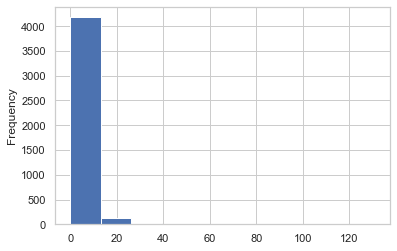

In [17]:
df_cust['frequency'].plot(kind='hist', bins=10)
print(df_cust['frequency'].describe())
print("---------------------------------------")
one_time_buyers = round(sum(df_cust['frequency'] == 0)/float(len(df_cust))*(100),2)
print("Percentage of 1-time-buyer (%):", one_time_buyers)

Now, let's fit the BG/NBD model to our summary df.

BG/NBD model is available as **BetaGeoFitter** class in lifetimes package.

In [18]:
bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(df_cust['frequency'], df_cust['recency'], df_cust['T'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826542,0.026785,0.774044,0.879040
alpha,68.905121,2.611786,63.786020,74.024221
a,0.003437,0.010339,-0.016828,0.023702
b,6.745116,22.414725,-37.187745,50.677978


The above table shows the estimated distribution parameter values from the historical data.

The model uses this output to predict the future transactions and the customer churn rate.

So, let's say you want to know whether a customer is now alive or not (or predict customer churn) based on the historical data. The lifetimes package provides a way to accomplish that task, we can use

**1. model.conditional_probability_alive():** This method computes the probability that a customer with history (frequency, recency, T) is currently alive.

**2. plot_probabilty_alive_matrix(model):** This function from lifetimes.plotting will help to visually analyze the relationship between recency & frequency and the customer being alive.

In [19]:
# Compute the customer alive probability
df_cust['probability_alive'] = bgf.conditional_probability_alive(df_cust['frequency'], df_cust['recency'], df_cust['T'])
df_cust.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive
0,12346.0,0.0,0.0,325.0,0.000000,1.000000
1,12347.0,6.0,365.0,367.0,599.701667,0.999698
2,12348.0,3.0,283.0,358.0,301.480000,0.999177
3,12349.0,0.0,0.0,18.0,0.000000,1.000000
4,12350.0,0.0,0.0,310.0,0.000000,1.000000


<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

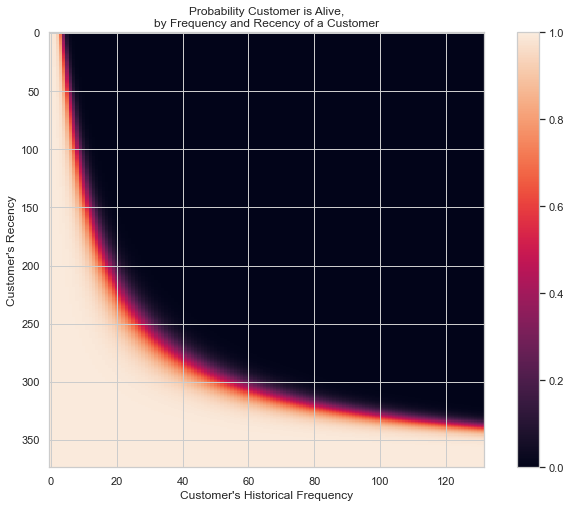

In [20]:
# Visual representation of relationship between recency and frequency
from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure(figsize=(12, 8))
plot_probability_alive_matrix(bgf)

The probabilty of being alive is calculated based on the recency and frequency of a customer. So,
* If a customer has bought multiple times (frequency) and the time between first & last transaction is high (recency), then his/her probability being alive is high.
* Similarly, if a customer has less frequency (bought once or twice) and the time between first & last transaction is low (recency), then his/her probability being alive is low.

Next thing we can do with this trained model is to predict the likely future transactions for each customer. We can use

**1. model.conditional_expected_number_of_purchases_up_to_time():** Calculate the expected number of repeat purchases up to time t for a randomly chosen individual from the population (or the whole population), given they have purchase history (frequency, recency, T).

In [21]:
t = 30
df_cust['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, df_cust['frequency'], df_cust['recency'], df_cust['T']), 2)
df_cust.sort_values(by='pred_num_txn', ascending=False).head(10).reset_index()

,index,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
0,1879,14911.0,131.0,372.0,373.0,1093.661679,0.999966,8.95
1,326,12748.0,112.0,373.0,373.0,301.024821,0.999971,7.66
2,4010,17841.0,111.0,372.0,373.0,364.452162,0.999962,7.59
3,2176,15311.0,89.0,373.0,373.0,677.729438,0.999964,6.10
4,1661,14606.0,88.0,372.0,373.0,135.890114,0.999955,6.03
5,481,12971.0,70.0,369.0,372.0,159.211286,0.999926,4.82
6,562,13089.0,65.0,367.0,369.0,893.714308,0.999934,4.51
7,1602,14527.0,53.0,367.0,369.0,155.016415,0.999925,3.69
8,1069,13798.0,52.0,371.0,372.0,706.650962,0.999933,3.59
9,2990,16422.0,47.0,352.0,369.0,702.472340,0.999567,3.27


We now have the prediction for number of purchases a customer will make in the next 10 days.

To check whether the predicted number makes sense, we can try something like this:

Let's take CustomerID - 14911,

*In 372 days, he purchased 131 times. So, in one day he purchases 131/372 = 0.352 times. Hence, for 10 days = 3.52 times.*

Here, our predicted result is 2.98 ((pred_num_txn/30)*10), which is close to the manual probability prediction we did above. The reason for the difference is caused by the various assumptions about the customers, such as the dropout rate, customers lifetime being modeled as exponential distribution, etc.


Now that we predicted the expected future transactions, we now need to predict the future monetary value of each transactions.

Like I have previously mentioned above, the BG/NBD model can only be able to predict the future transactions and churn rate of a customer. In order to add the monetary aspect of the problem, we have to model the monetary value using the **Gamma-Gamma Model**.

Key assumptions of Gamma-Gamma model are
1. The monetary value of a customer's given transaction varies randomly around their average transaction value.
2. Average transaction value varies across customers but do not vary over time for any given customer.
3. The distribution of average transaction values across customers is independent of the transaction process.

In [22]:
return_customers_summary = df_cust[df_cust['frequency']>0]
print(return_customers_summary.shape)
return_customers_summary.head()

(2790, 7)


,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
1,12347.0,6.0,365.0,367.0,599.701667,0.999698,0.47
2,12348.0,3.0,283.0,358.0,301.480000,0.999177,0.27
5,12352.0,6.0,260.0,296.0,368.256667,0.999406,0.56
9,12356.0,2.0,303.0,325.0,269.905000,0.999478,0.22
11,12358.0,1.0,149.0,150.0,683.200000,0.999486,0.25


In [23]:
return_customers_summary[['frequency', 'monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.015906
monetary_value,0.015906,1.000000


The correlation seems very weak. Hence, we can conclude that, the assumption is satisfied and we can fit the model to our data.

In [24]:
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(
       return_customers_summary['frequency'],
       return_customers_summary['monetary_value']
       )

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 11.13, q: 0.84, v: 11.29>

In [25]:
# Summary of the fitted parameters
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,11.125568,0.269274,10.597792,11.653344
q,0.838782,0.019731,0.800110,0.877455
v,11.292978,0.281539,10.741162,11.844795


Next, we can predict the expected average profit for each each transaction and CLV using below models

**1. model.conditional_expected_average_profit():** This method computes the conditional expectation of the average profit per transaction for a group of one or more customers.

**2. model.customer_lifetime_value():** This method computes the average lifetime value of a group of one or more customers. This method takes in BG/NBD model and the prediction horizon as a parameter to calculate the CLV.


In [26]:
df_cust = df_cust[df_cust['monetary_value'] >0]
df_cust['exp_avg_revenue'] = ggf.conditional_expected_average_profit(
                                                                df_cust['frequency'],
                                                                df_cust['monetary_value']
                                                                )
df_cust.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_revenue
1,12347.0,6.0,365.0,367.0,599.701667,0.999698,0.47,603.040247
2,12348.0,3.0,283.0,358.0,301.480000,0.999177,0.27,306.725889
5,12352.0,6.0,260.0,296.0,368.256667,0.999406,0.56,371.034926
9,12356.0,2.0,303.0,325.0,269.905000,0.999478,0.22,277.562534
11,12358.0,1.0,149.0,150.0,683.200000,0.999486,0.25,704.704679


**NOTE:** The reason why I have mentioned as expected average revenue is because the monetary value we are using is actual sales value not the profit. Using the above method, we got the average revenue and finally we can multiply the result by our profit margin to arrive at actual profit value.

In [27]:
print(f"Expected Revenue: {df_cust['exp_avg_revenue'].mean()}")
print(f"Actual Revenue: {df_cust['monetary_value'].mean()}")

Expected Revenue: 486.90902215126806
Actual Revenue: 477.3803385139518


The values seems to be fine. Now, let's calculate the CLV directly using the method from the lifetimes package.

Three main important thing to note here is:

**1. time:** This parameter in customer_lifetime_value() method takes in terms of months i.e., t=1 means one month and so on.

**2. freq:** This parameter is where you will specify the time unit your data is in. If your data is in daily level then "D", monthly "M" and so on.

**3. discount_rate:** This parameter is based on the concept of DCF (Discounted Cash Flow), where you will discount the future monetary value by a discount rate to get the present value of that cash flow. In the documentation, it is given that for monthly it is 0.01 (annually ~12.7%). 

In [28]:
# Predicting Customer Lifetime Value for the next 30 days
df_cust['predicted_clv'] = ggf.customer_lifetime_value(bgf,
                                                        df_cust['frequency'],
                                                        df_cust['recency'],
                                                        df_cust['T'],
                                                        df_cust['monetary_value'],
                                                        time=1,     # lifetime in months
                                                        freq='D',   # frequency in which the df is present(T)      
                                                        discount_rate=0.01
                                                        ) # discount rate
df_cust['manual_predicted_clv'] = df_cust['pred_num_txn'] * df_cust['exp_avg_revenue']
print(df_cust.head())
print("---------------------------------------")
print(f"We'll need multiple predicted CLV by 2 methods")


    CustomerID  frequency  recency      T  monetary_value  probability_alive  \
1      12347.0        6.0    365.0  367.0      599.701667           0.999698   
2      12348.0        3.0    283.0  358.0      301.480000           0.999177   
5      12352.0        6.0    260.0  296.0      368.256667           0.999406   
9      12356.0        2.0    303.0  325.0      269.905000           0.999478   
11     12358.0        1.0    149.0  150.0      683.200000           0.999486   

    pred_num_txn  exp_avg_revenue  predicted_clv  manual_predicted_clv  
1           0.47       603.040247     280.409518            283.428916  
2           0.27       306.725889      81.591026             82.815990  
5           0.56       371.034926     206.034640            207.779558  
9           0.22       277.562534      59.125290             61.063757  
11          0.25       704.704679     174.550478            176.176170  
---------------------------------------
We'll need multiple predicted CLV by 2 me

Both the CLV values are very close to each other and seems reasonable for the next 30 days.

One thing to note here is that, both the values we have calculated for CLV is the sales value, not the **actual profit**. To get the net profit for each customer, we can either create profit value in the begining by multiplying sales value with profit margin or we can do that now.

In [29]:
# CLV in terms of profit (profit margin is 5%)
profit_margin = 0.05
df_cust['CLV'] = df_cust['predicted_clv'] * profit_margin
df_cust.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_revenue,predicted_clv,manual_predicted_clv,CLV
1,12347.0,6.0,365.0,367.0,599.701667,0.999698,0.47,603.040247,280.409518,283.428916,14.020476
2,12348.0,3.0,283.0,358.0,301.480000,0.999177,0.27,306.725889,81.591026,82.815990,4.079551
5,12352.0,6.0,260.0,296.0,368.256667,0.999406,0.56,371.034926,206.034640,207.779558,10.301732
9,12356.0,2.0,303.0,325.0,269.905000,0.999478,0.22,277.562534,59.125290,61.063757,2.956265
11,12358.0,1.0,149.0,150.0,683.200000,0.999486,0.25,704.704679,174.550478,176.176170,8.727524


Finally, we predicted the CLV for each customers for the next 30 days. The marketing team could use this info to target customers and increase their sales.

Also, it is hard to target each individual customers. If we have access to customer demographics data, we can first create customer segmentation and then predict the CLV value for each segments. This segment level information can then be used for personalized targeting.